In [1]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
import seaborn as sns
import math

from sklearn.model_selection import GridSearchCV,ParameterGrid,train_test_split,validation_curve,learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import RobustScaler

from sklearn.metrics import classification_report,f1_score
from sklearn.pipeline import Pipeline

In [2]:
X_test = pd.read_csv('data_source/X_test.csv')
y_test = pd.read_csv('data_source/y_test.csv')

X_train = pd.read_csv('data_source/X_train.csv')
y_train = pd.read_csv('data_source/y_train.csv')

In [3]:
pipe = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier()) # object='multi:softmax',num_class=4,seed=42,eval_metric='merror'
])

hyperparameters = {
    'classifier__n_estimators': [5,6,7,8],  # Number of trees in the forest
    'classifier__max_depth': [3,4,5],  # Maximum depth of the trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at the leaf nodes
}

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Standardize the features
    ('classifier', RandomForestClassifier())  # Train a Random Forest classifier
])

# Set the hyperparameters for the Random Forest classifier
hyperparameters = {
    'classifier__n_estimators': [5,6,7,8],  # Number of trees in the forest
    'classifier__max_depth': [3,4,5],  # Maximum depth of the trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at the leaf nodes

}

In [5]:
grid = GridSearchCV(pipe,hyperparameters,cv=5)
grid.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

d:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
d:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
d:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
d:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please c

Best parameter (CV score=0.936):
{'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 5}
Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=4,
                                        min_samples_split=10,
                                        n_estimators=5))])


In [7]:
train_sizes, train_scores, test_scores = learning_curve(pipe, X_train, y_train, cv=5, scoring='f1_macro')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

d:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
d:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
d:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
d:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please c

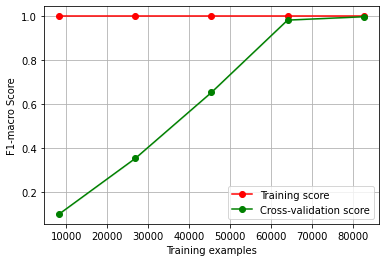

In [8]:
plt.figure()
plt.xlabel("Training examples")
plt.ylabel("F1-macro Score")

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

plt.legend(loc="best")

In [9]:
# Redefine the pipeline using result from gridsearch

Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=5, min_samples_split=10,
                                        min_samples_leaf=4,n_estimators=5))])

pipe.fit(X_train, y_train,)

print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Test set score: ' + str(pipe.score(X_test,y_test)))

d:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Training set score: 1.0
Test set score: 0.9974059003051882


In [17]:
pipe.fit(X_train, y_train)

train_yhat = pipe.predict(X_train)
train_pipe = pipe.score(X_train,y_train)

test_yhat = pipe.predict(X_test)
test_pipe = pipe.score(X_test,y_test)
print('Train Score\n',classification_report(y_train,train_yhat))
print('Test Score\n',classification_report(y_test, test_yhat))
print(f"AVG F1-Score Train: {train_pipe}\nAVG F1-Score Test: {test_pipe}")

d:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Train Score
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26036
           1       1.00      1.00      1.00     25387
           2       1.00      1.00      1.00     26234
           3       1.00      1.00      1.00     25669

    accuracy                           1.00    103326
   macro avg       1.00      1.00      1.00    103326
weighted avg       1.00      1.00      1.00    103326

Test Score
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11292
           1       1.00      0.99      0.99      4496
           2       1.00      1.00      1.00      3856
           3       0.24      0.50      0.33        16

    accuracy                           1.00     19660
   macro avg       0.81      0.87      0.83     19660
weighted avg       1.00      1.00      1.00     19660

AVG F1-Score Train: 1.0
AVG F1-Score Test: 0.997558494404883


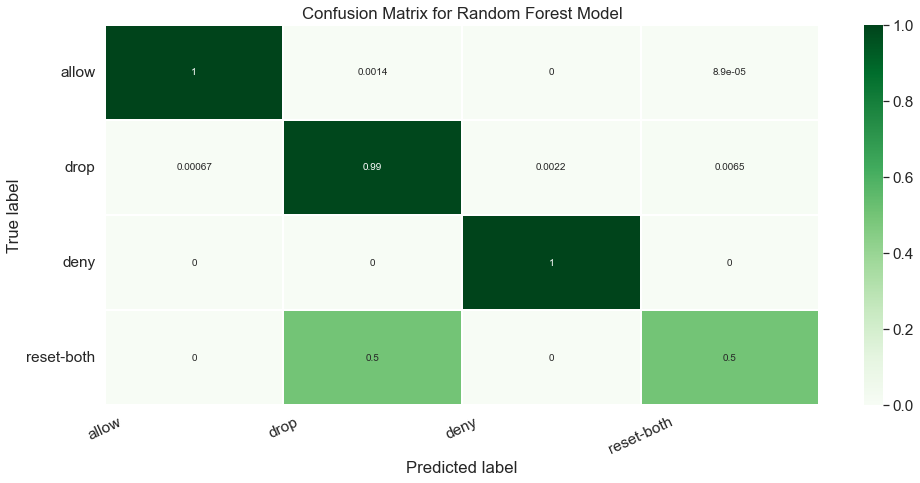

In [15]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, test_yhat)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['allow','drop','deny','reset-both']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# About 75% of the time, reset-both were mislabeled as drop!